In [1]:
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit
pdb = app.PDBFile('butane.pdb')
forcefield = app.ForceField('butane.gaff2.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

In [2]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528654036221 kJ/mol
Potential energy after minimization is 5.295784444937283 kJ/mol


In [3]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 250, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(5000)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,36.05758560333252,276.8625504638155
500,52.19157200473939,235.40694997726024
750,36.587560676547845,280.78991056837424
1000,53.672112347141905,239.0270442172113
1250,34.633036878180086,355.7250809436695
1500,36.78155591914501,503.5796473340101
1750,41.32437519571456,359.8177771490838
2000,49.14354635845191,260.36456007050856
2250,46.351201075089364,271.505839401424
2500,32.15161545047509,285.9425538359459
2750,50.1972800588828,254.26200282062268
3000,33.22957975512809,405.09169576261627
3250,61.411342620584776,408.6345089591258
3500,32.326539961371296,229.65999865138738
3750,29.224485545279535,233.27248709607633
4000,50.594091236695064,431.44185562823685
4250,32.687064612574105,275.36922885364754
4500,53.56172253960301,223.8298598318665
4750,28.136991184011446,489.1794172891284
5000,38.732704063233754,167.61793597173983


In [4]:
import time as time

print('Running Production')

# begin timer
tinit=time.time()

# clear simulation reporters
simulation.reporters.clear()

# reinitialize simulation reporters. Done because we want different information printed from the production run
# than the equilibriation run. 
# output basic simulation information below every 500,000 steps - 2 x 500,000 = 1,000,000fs or 1ns
simulation.reporters.append(app.StateDataReporter(stdout, 500000, step=True, time=True, potentialEnergy=True,
                            temperature=True, speed=True, separator=','))

# write traj to a DCD file every 100 steps - 0.2ps
simulation.reporters.append(app.DCDReporter('butane_sim.dcd', 100))

# run simulation for 2.0x10^7 steps - 40ns
simulation.step(20000000)

# end timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
500000,999.9999999901769,49.69542957404052,231.25900400690563,0
1000000,1999.9999999665301,36.30749118373592,343.6134144231927,1.59e+04
1500000,2999.9999999428833,42.14822659203023,324.05735204227733,1.5e+04
2000000,3999.9999999192364,54.60915595723155,287.3741766775191,1.44e+04
2500000,5000.000000101135,53.22783518393337,285.80750043680496,1.48e+04
3000000,6000.000000304862,35.29690486759805,292.65708278893015,1.48e+04
3500000,7000.0000005085885,53.267932083281615,197.73617424179008,1.48e+04
4000000,8000.000000712315,26.930763167915643,278.5556030135441,1.49e+04
4500000,9000.000000916041,34.814127441836774,213.99207778422704,1.49e+04
5000000,10000.000001119768,47.716465376333126,194.11460533170893,1.51e+04
5500000,11000.000001323495,40.284279056653446,143.38098834188514,1.51e+04
6000000,12000.000001527222,42.946061884276354,206.5010439183192,1.51e+04
6500000,13000.000001730948,52.417

In [5]:
import mdtraj as md

traj = md.load('butane_sim.dcd', top='butane.pdb')

In [6]:
import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=199999)

In [7]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [8]:
phi_indices = [0, 4, 7, 10] # atoms for torsion
phi = md.compute_dihedrals(traj, [phi_indices])

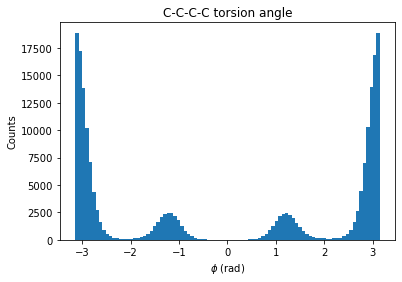

In [9]:
import matplotlib.pyplot as plt

phicounts, binedges, otherstuff = plt.hist(phi, bins=90)
plt.title('C-C-C-C torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

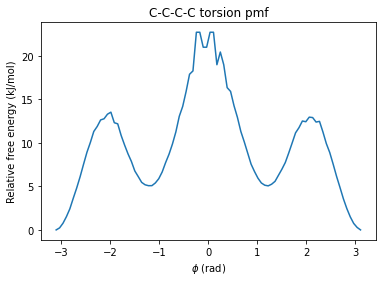

In [10]:
import numpy as np

kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C-C-C-C torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

In [11]:
theta_indices = [0, 4, 7] # atoms for bend
theta = md.compute_angles(traj, [theta_indices])

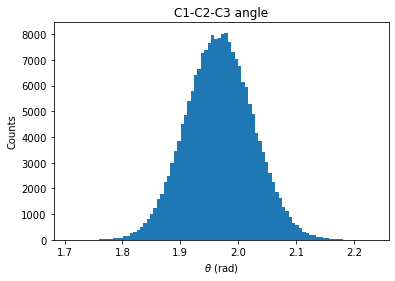

In [12]:
thetacounts, binedges, otherstuff = plt.hist(theta, bins=90)
plt.title('C1-C2-C3 angle')
plt.xlabel(r'$\theta$ (rad)')
plt.ylabel('Counts')
plt.show()

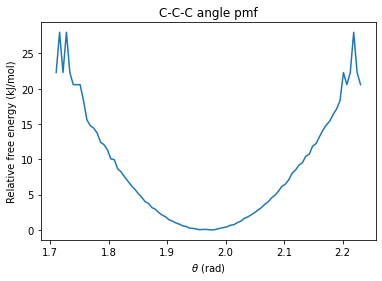

In [13]:
thetacounts[thetacounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(thetacounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C-C-C angle pmf')
plt.xlabel(r'$\theta$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

In [14]:
bond_indices = [0, 1] # atoms to define bond length
bond_length = md.compute_distances(traj, [bond_indices])

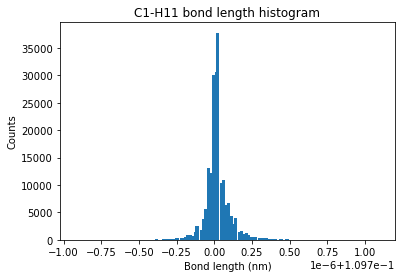

In [15]:
bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C1-H11 bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()